Seberapa besar variasi data?

Apakah mask-nya valid?

Apakah ada bias?

Apakah ada masalah resolusi?

Apakah flood area dominan kecil atau besar?

In [66]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image as Image
import cv2

## Preview Data

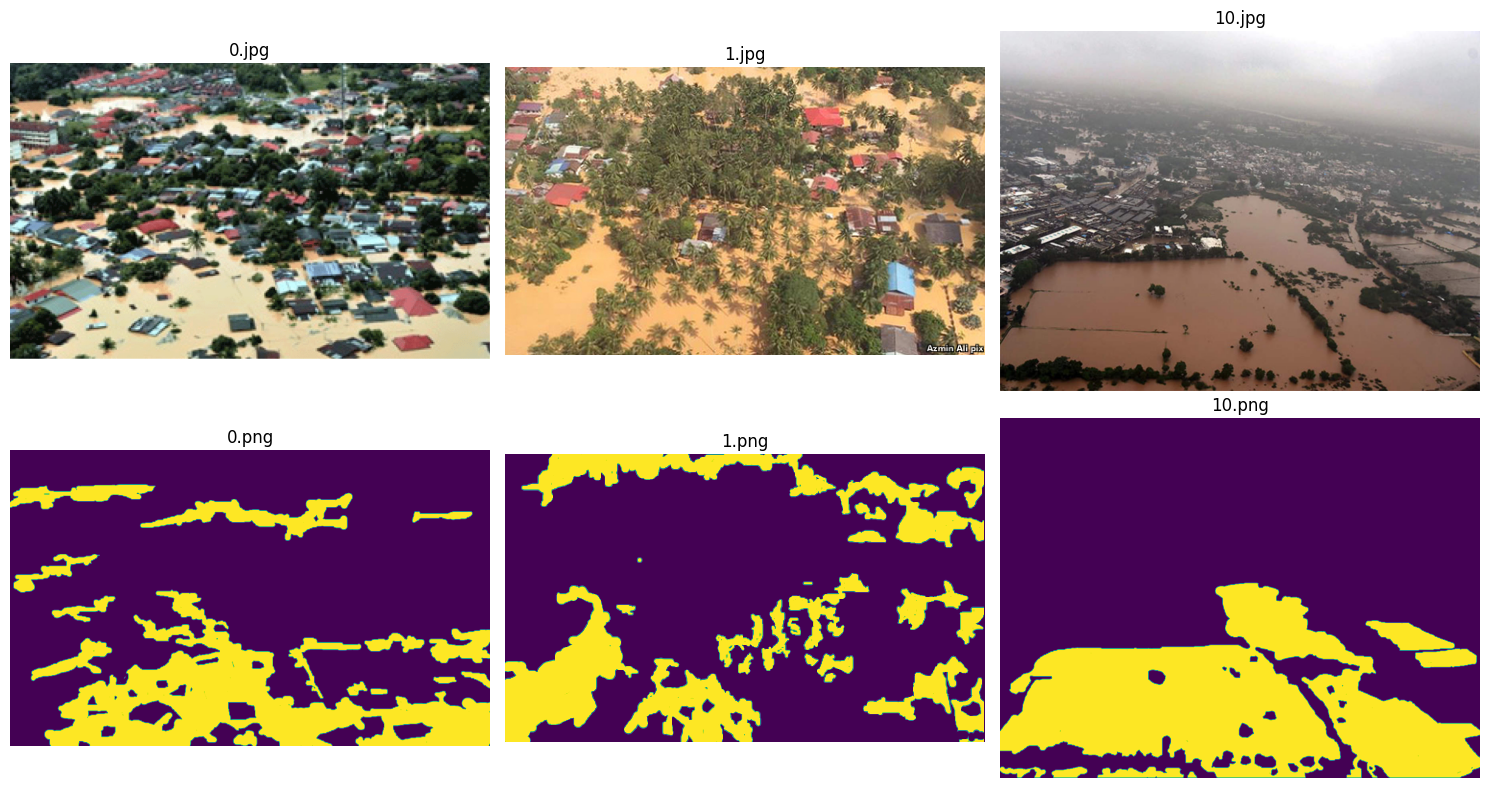

In [55]:
IMAGE_DIR = '../data/Image'
MASK_DIR = '../data/Mask'

def display_img(image_dir, mask_dir, n=3):
    img_files = os.listdir(image_dir)[:n]
    mask_files = os.listdir(mask_dir)[:n]
    fig, axes = plt.subplots(2, n, figsize=(5*n, 8))

    for i, fname in enumerate(img_files):
        img = Image.open(os.path.join(image_dir, fname))
        axes[0, i].set_title(fname)
        axes[0, i].imshow(img)
        axes[0, i].axis('off')

    for i, fname in enumerate(mask_files):
        mask = Image.open(os.path.join(mask_dir, fname))
        axes[1, i].set_title(fname)
        axes[1, i].imshow(mask)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

display_img(IMAGE_DIR, MASK_DIR)

## Variasi Data

In [56]:
var_img = os.listdir(IMAGE_DIR)
var_mask = os.listdir(MASK_DIR)
print(f'Gambar dalam folder {IMAGE_DIR} : {len(var_img)}')
print(f'Mask dalam folder {MASK_DIR} : {len(var_mask)}')

Gambar dalam folder ../data/Image : 290
Mask dalam folder ../data/Mask : 290


In [71]:
img = cv2.imread("../data/Image/12.jpg")
mask = cv2.imread("../data/Mask/12.png", 0)

print("path:", "../data/Image/12.jpg")
print("exists:", os.path.exists("../data/Image/12.jpg"))
print("img is None:", img is None)
print("shape:", None if img is None else img.shape)
print("dtype:", None if img is None else img.dtype)
print("min/max:", None if img is None else (img.min(), img.max()))


path: ../data/Image/12.jpg
exists: True
img is None: False
shape: (1425, 1900, 3)
dtype: uint8
min/max: (0, 255)


## Overlay

In [72]:
import cv2
import numpy as np

img = cv2.imread("../data/Image/12.jpg")
mask = cv2.imread("../data/Mask/12.png", 0)

# sanity check
print(img.shape, img.dtype)
print(mask.shape, mask.dtype)

# resize mask ke ukuran image
mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

# binarize
mask = (mask > 0).astype(np.uint8)

# overlay merah
overlay = img.copy()
overlay[mask == 1] = [0, 0, 255]

# transparansi
result = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)

cv2.imshow("overlay", result)
cv2.waitKey(0)
cv2.destroyAllWindows()


(1425, 1900, 3) uint8
(1425, 1900) uint8


In [ ]:
import cv2


def overlay(IMAGE_DIR, MASK_DIR, alpha=0.5):
    img = cv2.imread(IMAGE_DIR)
    mask = cv2.imread(MASK_DIR, cv2.IMREAD_GRAYSCALE)
    mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    overlayed = cv2.addWeighted(img, 1 - alpha, mask_colored, alpha, 0)
    
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    


img_path: ../data/Image\0.jpg exists: True size: 368278
mask_path: ../data/Mask\0.png exists: True size: 26107
PIL img mode/size: P (893, 551)
PIL mask mode/size: L (893, 551)
cv2 img read: None
cv2 mask read: (551, 893) dtype: uint8


In [61]:
from PIL import Image
import numpy as np
pil = Image.open(img).convert('RGB')
img_np = np.array(pil)[:, :, ::-1]  # RGB->BGR for cv2
# same for mask: open, convert('L'), np.array